In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__MACOSX', '__notebook__.ipynb', 'plates']


In [2]:
import random
import torch

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5973.98it/s]


In [5]:
!ls train

cleaned  dirty


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import roc_auc_score
from torchvision import transforms, models

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(75),
    transforms.ColorJitter(brightness=0.3, contrast=0.7, saturation=0.8, hue=0.3),
    transforms.RandomGrayscale(),
    transforms.CenterCrop((224, 224)),
    #transforms.RandomResizedCrop(224),
    #transforms.Resize((224, 224)),    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(4, 32)

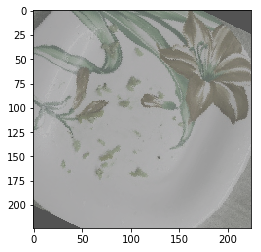

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

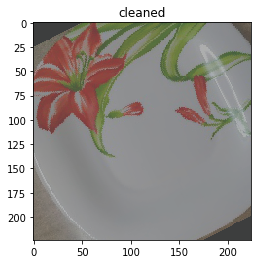

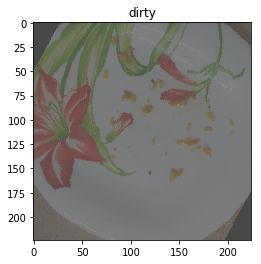

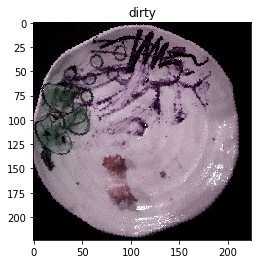

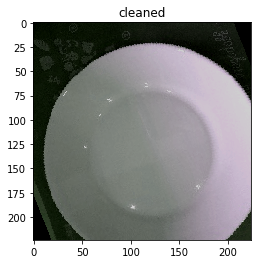

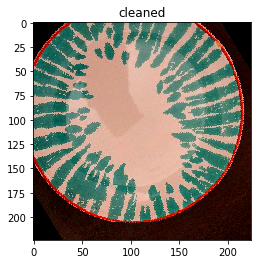

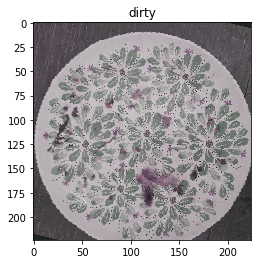

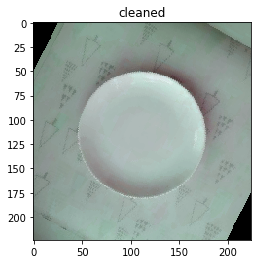

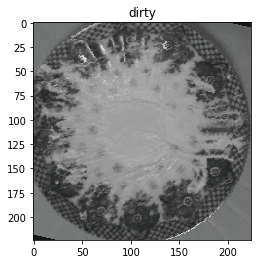

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
train_loss = []
train_acc = []
train_auc = []

val_loss = []
val_acc = []
val_auc = []

In [11]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.
            softmax_preds = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    softmax = torch.nn.Softmax(dim=1)
                    softmax_value = softmax(preds)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
                softmax_preds += roc_auc_score(labels.cpu().data, softmax_value[:, 1].detach().cpu().numpy())

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            epoch_auc = softmax_preds / len(dataloader)

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_auc.append(epoch_auc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                val_auc.append(epoch_auc)

    return model

In [12]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)
#model.my_act = torch.nn.Tanh()
#model.my_fc = torch.nn.Linear(model.fc.in_features // 2, 2)

#print(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 104171031.39it/s]


In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 1/99:



100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

Epoch 2/99:



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

Epoch 3/99:



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Epoch 4/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 5/99:



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 6/99:



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Epoch 7/99:



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 8/99:



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

Epoch 9/99:



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

Epoch 10/99:



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 11/99:



100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

Epoch 12/99:



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 13/99:



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Epoch 14/99:



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Epoch 15/99:



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Epoch 16/99:



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 17/99:



100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

Epoch 18/99:



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Epoch 19/99:



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Epoch 20/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 21/99:



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Epoch 22/99:



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Epoch 23/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 24/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 25/99:



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Epoch 26/99:



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

Epoch 27/99:



100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

Epoch 28/99:



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 29/99:



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

Epoch 30/99:



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

Epoch 31/99:



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

Epoch 32/99:



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Epoch 33/99:



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Epoch 34/99:



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Epoch 35/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 36/99:



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

Epoch 37/99:



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

Epoch 38/99:



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

Epoch 39/99:



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 40/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 41/99:



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Epoch 42/99:



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Epoch 43/99:



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

Epoch 44/99:



100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

Epoch 45/99:



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

Epoch 46/99:



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

Epoch 47/99:



100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

Epoch 48/99:



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

Epoch 49/99:



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

Epoch 50/99:



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

Epoch 51/99:



100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

Epoch 52/99:



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

Epoch 53/99:



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

Epoch 54/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 55/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 56/99:



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

Epoch 57/99:



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Epoch 58/99:



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

Epoch 59/99:



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

Epoch 60/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 61/99:



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

Epoch 62/99:



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

Epoch 63/99:



100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

Epoch 64/99:



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Epoch 65/99:



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Epoch 66/99:



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

Epoch 67/99:



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Epoch 68/99:



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Epoch 69/99:



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Epoch 70/99:



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 71/99:



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

Epoch 72/99:



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

Epoch 73/99:



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

Epoch 74/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 75/99:



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Epoch 76/99:



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Epoch 77/99:



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 78/99:



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Epoch 79/99:



100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

Epoch 80/99:



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Epoch 81/99:



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Epoch 82/99:



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 83/99:



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Epoch 84/99:



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 85/99:



100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

Epoch 86/99:



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

Epoch 87/99:



100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

Epoch 88/99:



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Epoch 89/99:



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Epoch 90/99:



100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

Epoch 91/99:



100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

Epoch 92/99:



100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

Epoch 93/99:



100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

Epoch 94/99:



100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

Epoch 95/99:



100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

Epoch 96/99:



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Epoch 97/99:



100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

Epoch 98/99:



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Epoch 99/99:



100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


0.471823473572731

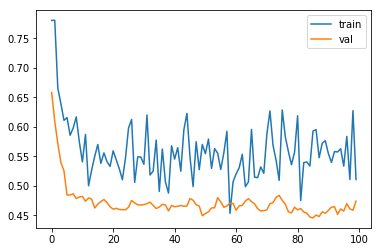

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(range(len(train_loss)), train_loss, label='train')
sns.lineplot(range(len(val_loss)), val_loss, label='val')

np.mean(val_loss)

0.85875

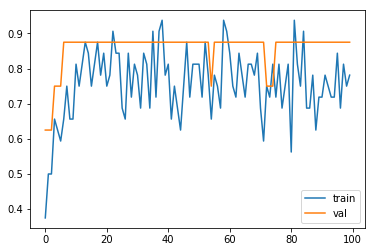

In [15]:
sns.lineplot(range(len(train_acc)), [x.cpu().item() for x in train_acc], label='train')
sns.lineplot(range(len(val_acc)), [x.cpu().item() for x in val_acc], label='val')

np.mean([x.cpu().item() for x in val_acc])

0.900625

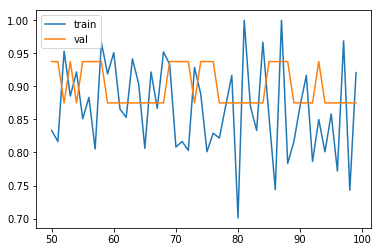

In [16]:
sns.lineplot(range(50, len(train_auc)), train_auc[50:], label='train')
sns.lineplot(range(50, len(val_auc)), val_auc[50:], label='val')

np.mean(val_auc)

In [17]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [18]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [19]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [20]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:04<00:00, 21.77it/s]


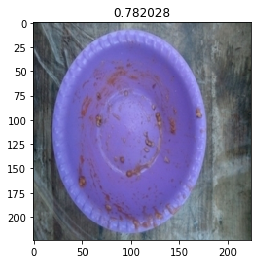

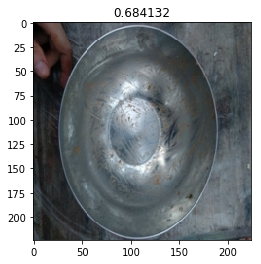

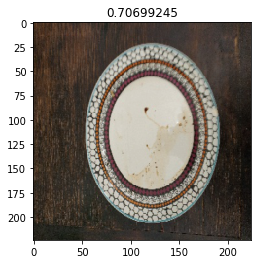

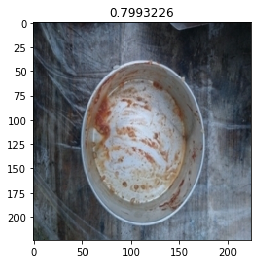

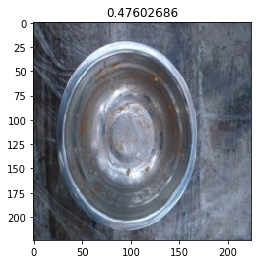

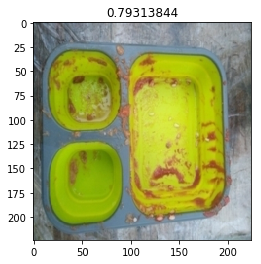

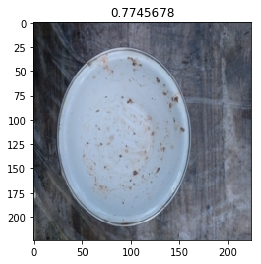

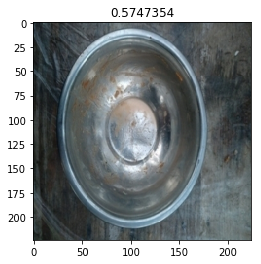

In [21]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [22]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [23]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,cleaned
0005,dirty


In [24]:
submission_df.to_csv('submission.csv')

In [25]:
!rm -rf train val test